## Preparing Enviornment

In [3]:
!pip install spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 59.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
import spacy
from spacy.training.example import Example
import random
import matplotlib.pyplot as plt
import IPython.core.display as display

## Reformatting the Annotation Tags into Training Data

In [6]:
def annotations_to_spacy(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)

    training_data = []

    for item in data:
        text = item["data"]["Text"]
        entities = []
        for tag in item["annotations"][0]["result"]:
            start = tag["value"]["start"]
            end = tag["value"]["end"]
            label = tag["value"]["labels"][0]
            entities.append((start, end, label))
        training_data.append((text, {"entities": entities}))
    return training_data

train_data = annotations_to_spacy("annotations-bbc-swahili.json")

In [7]:
print(f"Training data: {len(train_data)}" )

Training data: 5


## Training the Model

In [8]:
train, temp = train_test_split(train_data, test_size=0.4, random_state=42)
dev, test = train_test_split(temp, test_size=0.5, random_state=42)

print(f"Train: {len(train)}, Dev: {len(dev)}, and Test: {len(test)}")

Train: 3, Dev: 1, and Test: 1


In [ ]:
nlp = spacy.blank("xx")

ner = nlp.add_pipe("ner")

for _, annotations in train:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Initialize the model
optimizer = nlp.begin_training()

loss_plot = [] # Initialize an empty list to for loss value graph

for i in range(10):
    random.shuffle(train)
    losses = {}
    for text, annotations in train:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], sgd=optimizer, drop=0.4, losses=losses)
    loss_plot.append(losses["ner"])  # Store the NER loss
    print(f"Loss at epoch {i+1}: {losses['ner']}")

Loss at epoch 1: 1404.18603515625
Loss at epoch 2: 1329.95361328125
Loss at epoch 3: 933.4368896484375
Loss at epoch 4: 538.0811767578125
Loss at epoch 5: 184.8668975830078
Loss at epoch 6: 179.7562255859375
Loss at epoch 7: 177.9855194091797
Loss at epoch 8: 168.70045471191406
Loss at epoch 9: 299.466796875
Loss at epoch 10: 162.6055908203125


### Visualizaing the Model

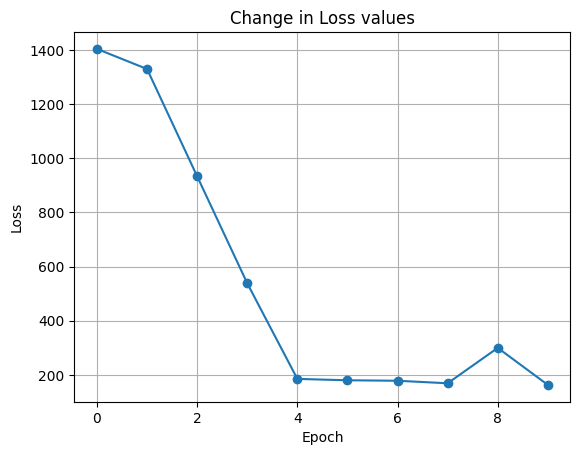

In [ ]:
plt.plot(range(10), loss_plot, marker='o')
plt.title("Change in Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("loss_plot_3.png")
plt.show()